In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import log_loss


#NLP tools
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
stopwords = nltk.corpus.stopwords.words('english')


#Plot and image tools
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style("dark")

train_data_path='./train.csv'

In [3]:
#Loading the Data
train = pd.read_csv(train_data_path)
test = pd.read_csv('./test.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# check the size of comments data
train.shape

(159571, 8)

In [6]:
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
train['clean'].sum()

143346

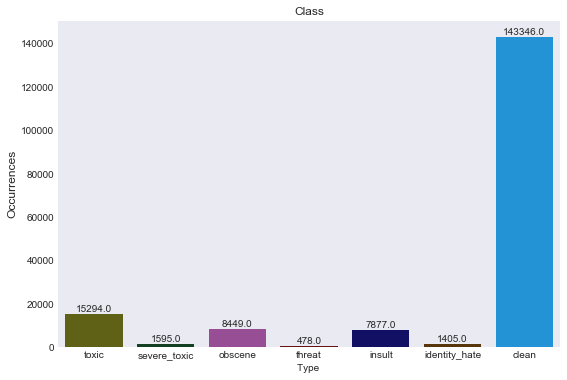

In [7]:
colors_list = ["brownish green", "pine green", "ugly purple",
               "blood", "deep blue", "brown", "azure"]

palette= sns.xkcd_palette(colors_list)

x=train.iloc[:,2:].sum()

plt.figure(figsize=(9,6))
ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type ')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')

plt.show()

In [8]:
# load the data into the list
comment_text_list = train.apply(lambda row : nltk.word_tokenize( row['comment_text']),axis=1)

In [9]:
#An odd comment contains a high rate of punctuation symbols or capital letters
rate_punctuation=0.7
rate_capital=0.7
def odd_comment(comment):
    punctuation_count=0
    capital_letter_count=0
    total_letter_count=0
    for token in comment:
        if token in list(string.punctuation):
            punctuation_count+=1
        capital_letter_count+=sum(1 for c in token if c.isupper())
        total_letter_count+=len(token)
    return((punctuation_count/len(comment))>=rate_punctuation or 
           (capital_letter_count/total_letter_count)>rate_capital)

odd=comment_text_list.apply(odd_comment)

In [10]:
odd_ones=odd[odd==True]
#list(ponctuation_polluted.index)
odd_comments=train.loc[list(odd_ones.index)]
odd_comments[odd_comments.clean==False].count()/len(odd_comments)

id               0.654298
comment_text     0.654298
toxic            0.654298
severe_toxic     0.654298
obscene          0.654298
threat           0.654298
insult           0.654298
identity_hate    0.654298
clean            0.654298
dtype: float64

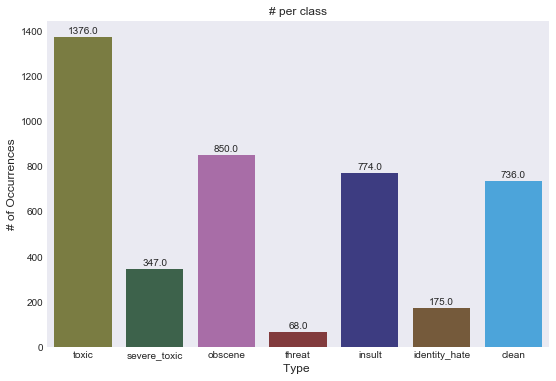

In [11]:
colors_list = ["brownish green", "pine green", "ugly purple",
               "blood", "deep blue", "brown", "azure"]

palette= sns.xkcd_palette(colors_list)

x=odd_comments.iloc[:,2:].sum()


plt.figure(figsize=(9,6))
ax= sns.barplot(x.index, x.values, alpha=0.8, palette=palette)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [12]:
# quick check for empty comments
empty_com=train[train.comment_text==""]
empty_com

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean


In [13]:
#quick check for duplicated comments
duplicate=train.comment_text.duplicated()
duplicate[duplicate==True]

Series([], Name: comment_text, dtype: bool)

In [14]:
#Just storing each categories of non clean comments in specific arrays
toxic=train[train.toxic==1]['comment_text'].values
severe_toxic=train[train.severe_toxic==1]['comment_text'].values
obscene=train[train.obscene==1]['comment_text'].values
threat=train[train.threat==1]['comment_text'].values
insult=train[train.insult==1]['comment_text'].values
identity_hate=train[train.identity_hate==1]['comment_text'].values

In [19]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

replacement_patterns = [
 (r'won\'t', 'will not'),
 (r'can\'t', 'cannot'),
 (r'i\'m', 'i am'),
 (r'ain\'t', 'is not'),
 (r'(\w+)\'ll', '\g<1> will'),
 (r'(\w+)n\'t', '\g<1> not'),
 (r'(\w+)\'ve', '\g<1> have'),
 (r'(\w+)\'s', '\g<1> is'),
 (r'(\w+)\'re', '\g<1> are'),
 (r'(\w+)\'d', '\g<1> would')
]

class RegexpReplacer(object):
    def __init__(self, patterns=replacement_patterns):
         self.patterns = [(re.compile(regex), repl) for (regex, repl) in
         patterns]
     
    def replace(self, text):
        s = text
        for (pattern, repl) in self.patterns:
             s = re.sub(pattern, repl, s)
        return s
    
lemmer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
replacer = RegexpReplacer()
tokenizer=TweetTokenizer()


def comment_process(comment):
        comment=tokenizer.tokenize(replacer.replace(comment))
        comment= [word for word in comment if ( word.lower() not in stopwords 
                              and word.lower() not in list(string.punctuation) )]
        comment=[lemmer.lemmatize(word, 'v') for word in comment]
        comment.extend(list(comment))
        comment=" ".join(comment)
        return comment
    

cleaned_train=train.comment_text.apply(comment_process)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer( strip_accents='unicode',analyzer='word', max_features= 50000, ngram_range=(4,4),
            use_idf=True,smooth_idf=True,sublinear_tf=True,
            stop_words = 'english')
cols=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y=train[cols]

xtrain, xvalid, ytrain, yvalid = train_test_split(cleaned_train, y, 
                                                  random_state=42, 
                                                  test_size=0.3, shuffle=True)

xtraintf=tf.fit_transform(xtrain)
xvalidtf=tf.fit_transform(xvalid)

We first like to try two methods of trianing our data, Bayes algorithm and logistic regression

In [22]:
#Second let's try logigstic regression
prd_valid = np.zeros((xvalidtf.shape[0],yvalid.shape[1]))
prd_train = np.zeros((xtraintf.shape[0],ytrain.shape[1]))
train_loss = []
valid_loss = []
bnb = LogisticRegression(penalty='l2')
for i,col in enumerate(cols):
    print('Building {} model for column:{''}'.format(i,col)) 
    bnb.fit(xtraintf,ytrain[col])
    prd_valid[:,i] = bnb.predict_proba(xvalidtf)[:,1]
    prd_train[:,i] = bnb.predict_proba(xtraintf)[:,1]
    train_loss_class=log_loss(ytrain[col],prd_train[:,i])
    valid_loss_class=log_loss(yvalid[col],prd_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))


Building 0 model for column:toxic
Trainloss=log loss: 0.29653937488
Validloss=log loss: 0.316020605404
Building 1 model for column:severe_toxic
Trainloss=log loss: 0.0524616366092
Validloss=log loss: 0.0567220079449
Building 2 model for column:obscene
Trainloss=log loss: 0.194927549132
Validloss=log loss: 0.208503788489
Building 3 model for column:threat
Trainloss=log loss: 0.0199885744777
Validloss=log loss: 0.019512216418
Building 4 model for column:insult
Trainloss=log loss: 0.185668421136
Validloss=log loss: 0.198275156651
Building 5 model for column:identity_hate
Trainloss=log loss: 0.0479511330914
Validloss=log loss: 0.0514615020105
mean column-wise log loss:Train dataset 0.132922781554
mean column-wise log loss:Validation dataset 0.141749212819


In [23]:
# first let's try Bayes algorithm
prd_valid = np.zeros((xvalidtf.shape[0],yvalid.shape[1]))
prd_train = np.zeros((xtraintf.shape[0],ytrain.shape[1]))
train_loss = []
valid_loss = []
bnb = BernoulliNB()
for i,col in enumerate(cols):
    print('Building {} model for column:{''}'.format(i,col)) 
    bnb.fit(xtraintf,ytrain[col])
    prd_valid[:,i] = bnb.predict_proba(xvalidtf)[:,1]
    prd_train[:,i] = bnb.predict_proba(xtraintf)[:,1]
    train_loss_class=log_loss(ytrain[col],prd_train[:,i])
    valid_loss_class=log_loss(yvalid[col],prd_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))

Building 0 model for column:toxic
Trainloss=log loss: 0.705256569317
Validloss=log loss: 1.74843989146
Building 1 model for column:severe_toxic
Trainloss=log loss: 0.853655407494
Validloss=log loss: 1.54297710214
Building 2 model for column:obscene
Trainloss=log loss: 0.881347879482
Validloss=log loss: 1.903090308
Building 3 model for column:threat
Trainloss=log loss: 0.45612641611
Validloss=log loss: 0.90548567975
Building 4 model for column:insult
Trainloss=log loss: 0.899059058627
Validloss=log loss: 1.90345054862
Building 5 model for column:identity_hate
Trainloss=log loss: 0.815565155579
Validloss=log loss: 1.46042393737
mean column-wise log loss:Train dataset 0.768501747768
mean column-wise log loss:Validation dataset 1.57731124456
